In [1]:
%reset -f
from __future__ import print_function
from __future__ import division
import math
import numpy as np
import torch
import sys
print('__Python VERSION:', sys.version)
print('__pyTorch VERSION:', torch.__version__)
print('__CUDA VERSION')
from subprocess import call
# call(["nvcc", "--version"]) does not work
! nvcc --version
print('__CUDNN VERSION:', torch.backends.cudnn.version())
print('__Number CUDA Devices:', torch.cuda.device_count())
print('__Devices')
call(["nvidia-smi", "--format=csv", "--query-gpu=index,name,driver_version,memory.total,memory.used,memory.free"])
print('Active CUDA Device: GPU', torch.cuda.current_device())

print ('Available devices ', torch.cuda.device_count())
print ('Current cuda device ', torch.cuda.current_device())
from torch import device as torch_device

#devices = [torch_device('cuda', i) for i in range(torch.cuda.device_count())] + [torch_device('cpu')]
#print(devices)
desired_gpu_index = 0
device = torch.device(f'cuda:{desired_gpu_index}')
device

__Python VERSION: 3.10.6 (main, Oct 24 2022, 16:07:47) [GCC 11.2.0]
__pyTorch VERSION: 2.0.1
__CUDA VERSION
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
__CUDNN VERSION: 8700
__Number CUDA Devices: 2
__Devices
index, name, driver_version, memory.total [MiB], memory.used [MiB], memory.free [MiB]
0, NVIDIA A100-PCIE-40GB, 525.125.06, 40960 MiB, 0 MiB, 40336 MiB
1, NVIDIA A100 80GB PCIe, 525.125.06, 81920 MiB, 80234 MiB, 817 MiB
Active CUDA Device: GPU 0
Available devices  2
Current cuda device  0


device(type='cuda', index=0)

In [2]:
import random
random.seed(20)
np.random.seed(20)
torch.manual_seed(20)
torch.cuda.manual_seed(20)
import cv2
import glob
from tqdm import tqdm
import skimage.io as io
import skimage.transform as trans
import matplotlib.pyplot as plt
import pydicom
import SimpleITK as sitk
import nibabel as nib
from scipy import ndimage
from torchmetrics import Dice
import torch.optim as optim

In [3]:
def dice_loss(pred, target):
    smooth = 1.#1e-5
    pred = pred.view(-1)
    target = target.view(-1)
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum()
    dice = (2.0 * intersection + smooth) / (union + smooth)
    return 1 - dice
def dice_coeff(pred, target):
    smooth = 1.#1e-5
    pred = pred.view(-1)
    target = target.view(-1)
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum()
    dice = (2.0 * intersection + smooth) / (union + smooth)
    return dice


import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable
from PIL import Image
import albumentations as A
import time
from tqdm.notebook import tqdm
from torchsummary import summary

In [4]:
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
# Define custom dataset class

def parse_image(img_path, image_size):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img ,image_size, interpolation = cv2.INTER_CUBIC)
    img = img.astype(np.float32)
    mn = np.amin(img)
    mx = np.amax(img)
    d = mx - mn
    img = (img-mn)/d
    #print(np.amax(img),np.amin(img))
    img = ToTensor()(img)
    #img = np.expand_dims(img, axis=2)
    #train_img = np.stack((image_rgb,)*3, axis=-1)
    
    return img

def parse_mask(img_path, image_size):
    mask_path = "/home/rabeea/Kvasir/masks/" + img_path.split('/')[-1]
    mask = cv2.imread(mask_path)
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    mask = np.where(mask>50,255,0)
    mask = cv2.resize(mask.astype(np.uint8),image_size, interpolation = cv2.INTER_NEAREST)
    #mask = np.expand_dims(mask, axis=2)
    mask = mask.astype(np.uint8)
    mask = np.where(mask>0,1,mask)
    mask = torch.from_numpy(mask).long()
    return mask

class DataGen(Dataset):
    def __init__(self, image_size, images_path , transform=None):
        self.image_size = image_size
        self.images_path = images_path
        self.batch_size = batch_size
        self.transform = transform

    def __len__(self):
        return len(self.images_path)

    def __getitem__(self, index):
        image = parse_image(self.images_path[index], self.image_size)
        mask = parse_mask(self.images_path[index], self.image_size)

        if self.transform is not None:
            image = self.transform(image)

        return image, mask


In [5]:
imgpath = glob.glob("/home/rabeea/Kvasir/images/*.jpg", recursive = True)
print(len(imgpath))

1000


In [6]:
tr = 700
val = 100
ts = 200
imgpath = sorted(imgpath)
random.Random(42).shuffle(imgpath)
trainpath = imgpath[:tr]
valpath = imgpath[tr:tr+val]
testpath = imgpath[tr+val:]
print(len(imgpath), len(trainpath), len(valpath), len(testpath))

1000 700 100 200


In [7]:
image_size = (256,256)
batch_size = 1

epochs = 350

train_steps = len(trainpath)//batch_size
valid_steps = len(valpath)//batch_size

## Generator
train_gen = DataGen(image_size, trainpath)
val_gen = DataGen(image_size,valpath)
test_gen = DataGen(image_size,testpath)

train_loader = DataLoader(train_gen, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_gen, batch_size=batch_size, shuffle=False)  
test_loader = DataLoader(test_gen, batch_size=1, shuffle=False) 

Feature batch shape: torch.Size([1, 1, 256, 256])
Labels batch shape: torch.Size([1, 256, 256])


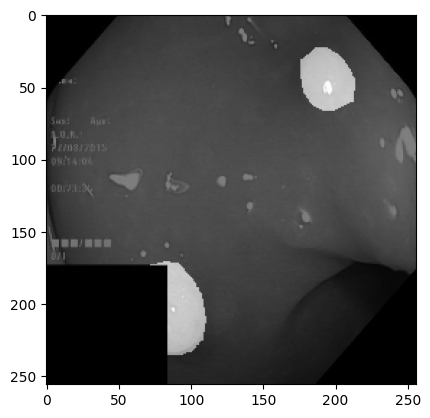

In [8]:
# Display image and label.
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.imshow(label, 'gray', alpha=0.5)

In [9]:
from torchvision import models
from torch.nn.functional import relu
class UNet(nn.Module):
    def __init__(self, n_class=1, f=64):
        super().__init__()
        
        # Encoder
        # In the encoder, convolutional layers with the Conv2d function are used to extract features from the input image. 
        # Each block in the encoder consists of two convolutional layers followed by a max-pooling layer, with the exception of the last block which does not include a max-pooling layer.
        # -------
        # input: 572x572x3
        self.e11 = nn.Conv2d(1, f, kernel_size=3, padding='same') # output: 570x570x64
        self.e12 = nn.Conv2d(f, f, kernel_size=3, padding='same') # output: 568x568x64
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 284x284x64

        # input: 284x284x64
        self.e21 = nn.Conv2d(f, f*2, kernel_size=3, padding='same') # output: 282x282x128
        self.e22 = nn.Conv2d(f*2, f*2, kernel_size=3, padding='same') # output: 280x280x128
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 140x140x128

        # input: 140x140x128
        self.e31 = nn.Conv2d(f*2, f*4, kernel_size=3, padding='same') # output: 138x138x256
        self.e32 = nn.Conv2d(f*4, f*4, kernel_size=3, padding='same') # output: 136x136x256
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 68x68x256

        # input: 68x68x256
        self.e41 = nn.Conv2d(f*4, f*8, kernel_size=3, padding='same') # output: 66x66x512
        self.e42 = nn.Conv2d(f*8, f*8, kernel_size=3, padding='same') # output: 64x64x512
        self.e4 = nn.Dropout(0.5)
#         self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 32x32x512

#         # input: 32x32x512
#         self.e51 = nn.Conv2d(512, 1024, kernel_size=3, padding='same') # output: 30x30x1024
#         self.e52 = nn.Conv2d(1024, 1024, kernel_size=3, padding='same') # output: 28x28x1024


        # Decoder
#         self.upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
#         self.d11 = nn.Conv2d(1024, 512, kernel_size=3, padding='same')
#         self.d12 = nn.Conv2d(512, 512, kernel_size=3, padding='same')

        self.upconv2 = nn.ConvTranspose2d(f*8, f*4, kernel_size=2, stride=2)
        self.d21 = nn.Conv2d(f*8, f*4, kernel_size=3, padding='same')
        self.d22 = nn.Conv2d(f*4, f*4, kernel_size=3, padding='same')

        self.upconv3 = nn.ConvTranspose2d(f*4, f*2, kernel_size=2, stride=2)
        self.d31 = nn.Conv2d(f*4, f*2, kernel_size=3, padding='same')
        self.d32 = nn.Conv2d(f*2, f*2, kernel_size=3, padding='same')

        self.upconv4 = nn.ConvTranspose2d(f*2, f, kernel_size=2, stride=2)
        self.d41 = nn.Conv2d(f*2, f, kernel_size=3, padding='same')
        self.d42 = nn.Conv2d(f, f, kernel_size=3, padding='same')
        

        # Output layer
        self.outconv = nn.Conv2d(f, n_class, kernel_size=1)
        
    def forward(self, x):
        # Encoder
        xe11 = relu(self.e11(x))
        xe12 = relu(self.e12(xe11))
        xp1 = self.pool1(xe12)

        xe21 = relu(self.e21(xp1))
        xe22 = relu(self.e22(xe21))
        xp2 = self.pool2(xe22)

        xe31 = relu(self.e31(xp2))
        xe32 = relu(self.e32(xe31))
        xp3 = self.pool3(xe32)

        xe41 = relu(self.e41(xp3))
        xe42 = relu(self.e42(xe41))
        xe4 = self.e4(xe42)
#        xp4 = self.pool4(xe42)

#         xe51 = relu(self.e51(xp4))
#         xe52 = relu(self.e52(xe51))
        
        # Decoder
#         xu1 = self.upconv1(xe52)
#         xu11 = torch.cat([xu1, xe42], dim=1)
#         xd11 = relu(self.d11(xu11))
#         xd12 = relu(self.d12(xd11))

        xu2 = self.upconv2(xe4)
        xu22 = torch.cat([xu2, xe32], dim=1)
        xd21 = relu(self.d21(xu22))
        xd22 = relu(self.d22(xd21))

        xu3 = self.upconv3(xd22)
        xu33 = torch.cat([xu3, xe22], dim=1)
        xd31 = relu(self.d31(xu33))
        xd32 = relu(self.d32(xd31))

        xu4 = self.upconv4(xd32)
        xu44 = torch.cat([xu4, xe12], dim=1)
        xd41 = relu(self.d41(xu44))
        xd42 = relu(self.d42(xd41))

        # Output layer
        out = self.outconv(xd42)
        out = F.sigmoid(out)

        return out

In [10]:
model = UNet(n_class=1, f=64)

In [11]:
model.to(device)

UNet(
  (e11): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (e12): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (e21): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (e22): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (e31): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (e32): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (e41): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (e42): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (e4): Dropout(p=0.5, inplace=False)
  (upconv2): ConvTranspose2d(512, 256, kernel_size=(2, 2), stride=(2, 2))
  (d21): Conv2d(512, 256, kern

In [12]:
filename_sd = '/home/rabeea/logs/Unettorc_polyp/polyp_64_ly4_lr5.pth'

In [13]:
optimizer = optim.Adam(model.parameters(), lr=1e-5)#, momentum=0.9)
torch.cuda.empty_cache()
max_dice = 0
train_losses = []
test_losses = []
train_dices = []
val_dices = []
decrease = 1  
fit_time = time.time()
not_improve=0
for epoch in range(epochs):
    # Your dataset or data loading logic goes here
    since = time.time()
    # Training
    model.train()
    train_loss = 0
    train_dice = 0
    num_batches = 0
    
    for i,data in enumerate(tqdm(train_loader)):  # Replace train_loader with your data loader
        inputs, labels = data
        # Forward pass
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        # Calculate loss
        loss = dice_loss(outputs, labels)
        
        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_dice += dice_coeff(outputs, labels).item()
        num_batches += 1
    
    train_loss /= num_batches
    train_dice /= num_batches
    
    # Validation
    model.eval()
    val_dice = 0.0
    test_loss = 0.0
    with torch.no_grad():
        for val_inputs, val_targets in val_loader:
            val_inputs = val_inputs.to(device)
            val_targets = val_targets.to(device)
            val_outputs = model(val_inputs)
            val_dice += dice_coeff(val_outputs,val_targets).item()
            test_loss += dice_loss(val_outputs,val_targets).item()
            
    val_dice /= len(val_loader)
    test_loss /= len(val_loader)
    # Perform validation and calculate validation loss and dice coefficient
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_dices.append(train_dice)
    val_dices.append(val_dice)
    if max_dice < val_dice:
        print('Dice increasing.. {:.3f} >> {:.3f} '.format(max_dice, val_dice))
        max_dice = val_dice
        decrease += 1
        not_improve = 0
        #if decrease % 5 == 0:
        print('saving model...')
        #torch.save(model, 'TransAttUNetSkip-{:.3f}.pt'.format(val_dice))
        #torch.save(model, filename)
        torch.save(model.state_dict(), filename_sd)
    if max_dice > val_dice:
        not_improve += 1
#         min_loss = test_loss
#         print(f'Loss Not Decrease for {not_improve} time')
        if not_improve == 30:
            print('Loss hasnt decreased for 30 epochs, Stopping Training')
            break
    
    # Print the metrics+
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Dice: {train_dice:.4f}, Val Dice: {val_dice:.4f}, time: {((time.time() - since)/60):.2f}")

    

  0%|          | 0/700 [00:00<?, ?it/s]

Dice increasing.. 0.000 >> 0.424 
saving model...
Epoch 1/350, Train Loss: 0.7123, Train Dice: 0.2877, Val Dice: 0.4239, time: 0.30


  0%|          | 0/700 [00:00<?, ?it/s]

Dice increasing.. 0.424 >> 0.427 
saving model...
Epoch 2/350, Train Loss: 0.6440, Train Dice: 0.3560, Val Dice: 0.4267, time: 0.28


  0%|          | 0/700 [00:00<?, ?it/s]

Epoch 3/350, Train Loss: 0.6396, Train Dice: 0.3604, Val Dice: 0.4114, time: 0.27


  0%|          | 0/700 [00:00<?, ?it/s]

Epoch 4/350, Train Loss: 0.6372, Train Dice: 0.3628, Val Dice: 0.4172, time: 0.27


  0%|          | 0/700 [00:00<?, ?it/s]

Epoch 5/350, Train Loss: 0.6366, Train Dice: 0.3634, Val Dice: 0.4232, time: 0.29


  0%|          | 0/700 [00:00<?, ?it/s]

Epoch 6/350, Train Loss: 0.6328, Train Dice: 0.3672, Val Dice: 0.4230, time: 0.30


  0%|          | 0/700 [00:00<?, ?it/s]

Epoch 7/350, Train Loss: 0.6279, Train Dice: 0.3721, Val Dice: 0.4210, time: 0.28


  0%|          | 0/700 [00:00<?, ?it/s]

Dice increasing.. 0.427 >> 0.428 
saving model...
Epoch 8/350, Train Loss: 0.6235, Train Dice: 0.3765, Val Dice: 0.4284, time: 0.29


  0%|          | 0/700 [00:00<?, ?it/s]

Dice increasing.. 0.428 >> 0.449 
saving model...
Epoch 9/350, Train Loss: 0.6215, Train Dice: 0.3785, Val Dice: 0.4485, time: 0.29


  0%|          | 0/700 [00:00<?, ?it/s]

Epoch 10/350, Train Loss: 0.6140, Train Dice: 0.3860, Val Dice: 0.4371, time: 0.29


  0%|          | 0/700 [00:00<?, ?it/s]

Dice increasing.. 0.449 >> 0.454 
saving model...
Epoch 11/350, Train Loss: 0.6050, Train Dice: 0.3950, Val Dice: 0.4540, time: 0.40


  0%|          | 0/700 [00:00<?, ?it/s]

Dice increasing.. 0.454 >> 0.471 
saving model...
Epoch 12/350, Train Loss: 0.6053, Train Dice: 0.3947, Val Dice: 0.4707, time: 0.44


  0%|          | 0/700 [00:00<?, ?it/s]

Epoch 13/350, Train Loss: 0.5967, Train Dice: 0.4033, Val Dice: 0.4501, time: 0.42


  0%|          | 0/700 [00:00<?, ?it/s]

Dice increasing.. 0.471 >> 0.474 
saving model...
Epoch 14/350, Train Loss: 0.5987, Train Dice: 0.4013, Val Dice: 0.4739, time: 0.43


  0%|          | 0/700 [00:00<?, ?it/s]

Epoch 15/350, Train Loss: 0.5897, Train Dice: 0.4103, Val Dice: 0.4724, time: 0.44


  0%|          | 0/700 [00:00<?, ?it/s]

Dice increasing.. 0.474 >> 0.497 
saving model...
Epoch 16/350, Train Loss: 0.5873, Train Dice: 0.4127, Val Dice: 0.4967, time: 0.42


  0%|          | 0/700 [00:00<?, ?it/s]

Epoch 17/350, Train Loss: 0.5787, Train Dice: 0.4213, Val Dice: 0.4961, time: 0.42


  0%|          | 0/700 [00:00<?, ?it/s]

Dice increasing.. 0.497 >> 0.507 
saving model...
Epoch 18/350, Train Loss: 0.5742, Train Dice: 0.4258, Val Dice: 0.5069, time: 0.43


  0%|          | 0/700 [00:00<?, ?it/s]

Dice increasing.. 0.507 >> 0.509 
saving model...
Epoch 19/350, Train Loss: 0.5771, Train Dice: 0.4229, Val Dice: 0.5094, time: 0.43


  0%|          | 0/700 [00:00<?, ?it/s]

Dice increasing.. 0.509 >> 0.519 
saving model...
Epoch 20/350, Train Loss: 0.5697, Train Dice: 0.4303, Val Dice: 0.5189, time: 0.43


  0%|          | 0/700 [00:00<?, ?it/s]

Epoch 21/350, Train Loss: 0.5625, Train Dice: 0.4375, Val Dice: 0.5152, time: 0.43


  0%|          | 0/700 [00:00<?, ?it/s]

Epoch 22/350, Train Loss: 0.5589, Train Dice: 0.4411, Val Dice: 0.5108, time: 0.44


  0%|          | 0/700 [00:00<?, ?it/s]

Epoch 23/350, Train Loss: 0.5572, Train Dice: 0.4428, Val Dice: 0.5114, time: 0.43


  0%|          | 0/700 [00:00<?, ?it/s]

Epoch 24/350, Train Loss: 0.5541, Train Dice: 0.4459, Val Dice: 0.5161, time: 0.44


  0%|          | 0/700 [00:00<?, ?it/s]

Dice increasing.. 0.519 >> 0.523 
saving model...
Epoch 25/350, Train Loss: 0.5508, Train Dice: 0.4492, Val Dice: 0.5225, time: 0.49


  0%|          | 0/700 [00:00<?, ?it/s]

Dice increasing.. 0.523 >> 0.531 
saving model...
Epoch 26/350, Train Loss: 0.5499, Train Dice: 0.4501, Val Dice: 0.5307, time: 0.53


  0%|          | 0/700 [00:00<?, ?it/s]

Epoch 27/350, Train Loss: 0.5462, Train Dice: 0.4538, Val Dice: 0.5292, time: 0.44


  0%|          | 0/700 [00:00<?, ?it/s]

Dice increasing.. 0.531 >> 0.532 
saving model...
Epoch 28/350, Train Loss: 0.5410, Train Dice: 0.4590, Val Dice: 0.5325, time: 0.43


  0%|          | 0/700 [00:00<?, ?it/s]

Epoch 29/350, Train Loss: 0.5388, Train Dice: 0.4612, Val Dice: 0.5235, time: 0.42


  0%|          | 0/700 [00:00<?, ?it/s]

Epoch 30/350, Train Loss: 0.5377, Train Dice: 0.4623, Val Dice: 0.5244, time: 0.44


  0%|          | 0/700 [00:00<?, ?it/s]

Dice increasing.. 0.532 >> 0.541 
saving model...
Epoch 31/350, Train Loss: 0.5323, Train Dice: 0.4677, Val Dice: 0.5415, time: 0.43


  0%|          | 0/700 [00:00<?, ?it/s]

Epoch 32/350, Train Loss: 0.5307, Train Dice: 0.4693, Val Dice: 0.5381, time: 0.43


  0%|          | 0/700 [00:00<?, ?it/s]

Epoch 33/350, Train Loss: 0.5264, Train Dice: 0.4736, Val Dice: 0.5327, time: 0.45


  0%|          | 0/700 [00:00<?, ?it/s]

Epoch 34/350, Train Loss: 0.5279, Train Dice: 0.4721, Val Dice: 0.5371, time: 0.48


  0%|          | 0/700 [00:00<?, ?it/s]

Epoch 35/350, Train Loss: 0.5231, Train Dice: 0.4769, Val Dice: 0.5405, time: 0.44


  0%|          | 0/700 [00:00<?, ?it/s]

Dice increasing.. 0.541 >> 0.544 
saving model...
Epoch 36/350, Train Loss: 0.5172, Train Dice: 0.4828, Val Dice: 0.5438, time: 0.46


  0%|          | 0/700 [00:00<?, ?it/s]

Dice increasing.. 0.544 >> 0.551 
saving model...
Epoch 37/350, Train Loss: 0.5147, Train Dice: 0.4853, Val Dice: 0.5512, time: 0.45


  0%|          | 0/700 [00:00<?, ?it/s]

Epoch 38/350, Train Loss: 0.5104, Train Dice: 0.4896, Val Dice: 0.5494, time: 0.44


  0%|          | 0/700 [00:00<?, ?it/s]

Dice increasing.. 0.551 >> 0.553 
saving model...
Epoch 39/350, Train Loss: 0.5127, Train Dice: 0.4873, Val Dice: 0.5533, time: 0.44


  0%|          | 0/700 [00:00<?, ?it/s]

Dice increasing.. 0.553 >> 0.558 
saving model...
Epoch 40/350, Train Loss: 0.5068, Train Dice: 0.4932, Val Dice: 0.5583, time: 0.57


  0%|          | 0/700 [00:00<?, ?it/s]

Epoch 41/350, Train Loss: 0.5032, Train Dice: 0.4968, Val Dice: 0.5488, time: 0.45


  0%|          | 0/700 [00:00<?, ?it/s]

Dice increasing.. 0.558 >> 0.561 
saving model...
Epoch 42/350, Train Loss: 0.4998, Train Dice: 0.5002, Val Dice: 0.5610, time: 0.47


  0%|          | 0/700 [00:00<?, ?it/s]

Epoch 43/350, Train Loss: 0.4953, Train Dice: 0.5047, Val Dice: 0.5609, time: 0.43


  0%|          | 0/700 [00:00<?, ?it/s]

Dice increasing.. 0.561 >> 0.571 
saving model...
Epoch 44/350, Train Loss: 0.4988, Train Dice: 0.5012, Val Dice: 0.5714, time: 0.45


  0%|          | 0/700 [00:00<?, ?it/s]

Epoch 45/350, Train Loss: 0.4916, Train Dice: 0.5084, Val Dice: 0.5694, time: 0.46


  0%|          | 0/700 [00:00<?, ?it/s]

Epoch 46/350, Train Loss: 0.4900, Train Dice: 0.5100, Val Dice: 0.5651, time: 0.45


  0%|          | 0/700 [00:00<?, ?it/s]

Epoch 47/350, Train Loss: 0.4832, Train Dice: 0.5168, Val Dice: 0.5711, time: 0.45


  0%|          | 0/700 [00:00<?, ?it/s]

Epoch 48/350, Train Loss: 0.4802, Train Dice: 0.5198, Val Dice: 0.5662, time: 0.46


  0%|          | 0/700 [00:00<?, ?it/s]

Dice increasing.. 0.571 >> 0.579 
saving model...
Epoch 49/350, Train Loss: 0.4815, Train Dice: 0.5185, Val Dice: 0.5785, time: 0.46


  0%|          | 0/700 [00:00<?, ?it/s]

Epoch 50/350, Train Loss: 0.4738, Train Dice: 0.5262, Val Dice: 0.5754, time: 0.46


  0%|          | 0/700 [00:00<?, ?it/s]

Dice increasing.. 0.579 >> 0.581 
saving model...
Epoch 51/350, Train Loss: 0.4690, Train Dice: 0.5310, Val Dice: 0.5814, time: 0.43


  0%|          | 0/700 [00:00<?, ?it/s]

Epoch 52/350, Train Loss: 0.4674, Train Dice: 0.5326, Val Dice: 0.5671, time: 0.45


  0%|          | 0/700 [00:00<?, ?it/s]

Dice increasing.. 0.581 >> 0.582 
saving model...
Epoch 53/350, Train Loss: 0.4618, Train Dice: 0.5382, Val Dice: 0.5824, time: 0.46


  0%|          | 0/700 [00:00<?, ?it/s]

Dice increasing.. 0.582 >> 0.584 
saving model...
Epoch 54/350, Train Loss: 0.4613, Train Dice: 0.5387, Val Dice: 0.5840, time: 0.56


  0%|          | 0/700 [00:00<?, ?it/s]

Epoch 55/350, Train Loss: 0.4548, Train Dice: 0.5452, Val Dice: 0.5802, time: 0.44


  0%|          | 0/700 [00:00<?, ?it/s]

Epoch 56/350, Train Loss: 0.4528, Train Dice: 0.5472, Val Dice: 0.5832, time: 0.45


  0%|          | 0/700 [00:00<?, ?it/s]

Dice increasing.. 0.584 >> 0.584 
saving model...
Epoch 57/350, Train Loss: 0.4472, Train Dice: 0.5528, Val Dice: 0.5845, time: 0.45


  0%|          | 0/700 [00:00<?, ?it/s]

Dice increasing.. 0.584 >> 0.588 
saving model...
Epoch 58/350, Train Loss: 0.4419, Train Dice: 0.5581, Val Dice: 0.5885, time: 0.47


  0%|          | 0/700 [00:00<?, ?it/s]

Epoch 59/350, Train Loss: 0.4356, Train Dice: 0.5644, Val Dice: 0.5876, time: 0.47


  0%|          | 0/700 [00:00<?, ?it/s]

Epoch 60/350, Train Loss: 0.4315, Train Dice: 0.5685, Val Dice: 0.5885, time: 0.48


  0%|          | 0/700 [00:00<?, ?it/s]

Dice increasing.. 0.588 >> 0.589 
saving model...
Epoch 61/350, Train Loss: 0.4303, Train Dice: 0.5697, Val Dice: 0.5888, time: 0.46


  0%|          | 0/700 [00:00<?, ?it/s]

Epoch 62/350, Train Loss: 0.4231, Train Dice: 0.5769, Val Dice: 0.5796, time: 0.45


  0%|          | 0/700 [00:00<?, ?it/s]

Dice increasing.. 0.589 >> 0.591 
saving model...
Epoch 63/350, Train Loss: 0.4157, Train Dice: 0.5843, Val Dice: 0.5905, time: 0.45


  0%|          | 0/700 [00:00<?, ?it/s]

Dice increasing.. 0.591 >> 0.595 
saving model...
Epoch 64/350, Train Loss: 0.4161, Train Dice: 0.5839, Val Dice: 0.5951, time: 0.48


  0%|          | 0/700 [00:00<?, ?it/s]

Epoch 65/350, Train Loss: 0.4054, Train Dice: 0.5946, Val Dice: 0.5872, time: 0.46


  0%|          | 0/700 [00:00<?, ?it/s]

Epoch 66/350, Train Loss: 0.4035, Train Dice: 0.5965, Val Dice: 0.5931, time: 0.49


  0%|          | 0/700 [00:00<?, ?it/s]

Epoch 67/350, Train Loss: 0.3981, Train Dice: 0.6019, Val Dice: 0.5948, time: 0.43


  0%|          | 0/700 [00:00<?, ?it/s]

Epoch 68/350, Train Loss: 0.3958, Train Dice: 0.6042, Val Dice: 0.5787, time: 0.55


  0%|          | 0/700 [00:00<?, ?it/s]

Epoch 69/350, Train Loss: 0.3904, Train Dice: 0.6096, Val Dice: 0.5921, time: 0.45


  0%|          | 0/700 [00:00<?, ?it/s]

Epoch 70/350, Train Loss: 0.3905, Train Dice: 0.6095, Val Dice: 0.5889, time: 0.45


  0%|          | 0/700 [00:00<?, ?it/s]

Epoch 71/350, Train Loss: 0.3851, Train Dice: 0.6149, Val Dice: 0.5854, time: 0.48


  0%|          | 0/700 [00:00<?, ?it/s]

Epoch 72/350, Train Loss: 0.3787, Train Dice: 0.6213, Val Dice: 0.5879, time: 0.45


  0%|          | 0/700 [00:00<?, ?it/s]

Epoch 73/350, Train Loss: 0.3749, Train Dice: 0.6251, Val Dice: 0.5892, time: 0.47


  0%|          | 0/700 [00:00<?, ?it/s]

Epoch 74/350, Train Loss: 0.3660, Train Dice: 0.6340, Val Dice: 0.5844, time: 0.48


  0%|          | 0/700 [00:00<?, ?it/s]

Epoch 75/350, Train Loss: 0.3648, Train Dice: 0.6352, Val Dice: 0.5796, time: 0.47


  0%|          | 0/700 [00:00<?, ?it/s]

Dice increasing.. 0.595 >> 0.602 
saving model...
Epoch 76/350, Train Loss: 0.3625, Train Dice: 0.6375, Val Dice: 0.6023, time: 0.45


  0%|          | 0/700 [00:00<?, ?it/s]

Epoch 77/350, Train Loss: 0.3537, Train Dice: 0.6463, Val Dice: 0.5750, time: 0.47


  0%|          | 0/700 [00:00<?, ?it/s]

Dice increasing.. 0.602 >> 0.610 
saving model...
Epoch 78/350, Train Loss: 0.3496, Train Dice: 0.6504, Val Dice: 0.6102, time: 0.47


  0%|          | 0/700 [00:00<?, ?it/s]

Epoch 79/350, Train Loss: 0.3478, Train Dice: 0.6522, Val Dice: 0.5938, time: 0.47


  0%|          | 0/700 [00:00<?, ?it/s]

Epoch 80/350, Train Loss: 0.3452, Train Dice: 0.6548, Val Dice: 0.5787, time: 0.44


  0%|          | 0/700 [00:00<?, ?it/s]

Epoch 81/350, Train Loss: 0.3375, Train Dice: 0.6625, Val Dice: 0.6071, time: 0.48


  0%|          | 0/700 [00:00<?, ?it/s]

Epoch 82/350, Train Loss: 0.3339, Train Dice: 0.6661, Val Dice: 0.6101, time: 0.55


  0%|          | 0/700 [00:00<?, ?it/s]

Epoch 83/350, Train Loss: 0.3264, Train Dice: 0.6736, Val Dice: 0.5983, time: 0.48


  0%|          | 0/700 [00:00<?, ?it/s]

Epoch 84/350, Train Loss: 0.3249, Train Dice: 0.6751, Val Dice: 0.6024, time: 0.45


  0%|          | 0/700 [00:00<?, ?it/s]

Epoch 85/350, Train Loss: 0.3240, Train Dice: 0.6760, Val Dice: 0.5906, time: 0.45


  0%|          | 0/700 [00:00<?, ?it/s]

Epoch 86/350, Train Loss: 0.3203, Train Dice: 0.6797, Val Dice: 0.6099, time: 0.46


  0%|          | 0/700 [00:00<?, ?it/s]

Dice increasing.. 0.610 >> 0.614 
saving model...
Epoch 87/350, Train Loss: 0.3139, Train Dice: 0.6861, Val Dice: 0.6141, time: 0.46


  0%|          | 0/700 [00:00<?, ?it/s]

Epoch 88/350, Train Loss: 0.3073, Train Dice: 0.6927, Val Dice: 0.5786, time: 0.44


  0%|          | 0/700 [00:00<?, ?it/s]

Dice increasing.. 0.614 >> 0.618 
saving model...
Epoch 92/350, Train Loss: 0.2929, Train Dice: 0.7071, Val Dice: 0.6184, time: 0.46


  0%|          | 0/700 [00:00<?, ?it/s]

Epoch 93/350, Train Loss: 0.2917, Train Dice: 0.7083, Val Dice: 0.6127, time: 0.48


  0%|          | 0/700 [00:00<?, ?it/s]

Epoch 94/350, Train Loss: 0.2916, Train Dice: 0.7084, Val Dice: 0.6164, time: 0.49


  0%|          | 0/700 [00:00<?, ?it/s]

Epoch 95/350, Train Loss: 0.2845, Train Dice: 0.7155, Val Dice: 0.6171, time: 0.56


  0%|          | 0/700 [00:00<?, ?it/s]

Epoch 96/350, Train Loss: 0.2777, Train Dice: 0.7223, Val Dice: 0.6115, time: 0.49


  0%|          | 0/700 [00:00<?, ?it/s]

Dice increasing.. 0.618 >> 0.622 
saving model...
Epoch 97/350, Train Loss: 0.2758, Train Dice: 0.7242, Val Dice: 0.6218, time: 0.50


  0%|          | 0/700 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch 113/350, Train Loss: 0.2211, Train Dice: 0.7789, Val Dice: 0.6009, time: 0.46


  0%|          | 0/700 [00:00<?, ?it/s]

Epoch 114/350, Train Loss: 0.2179, Train Dice: 0.7821, Val Dice: 0.5603, time: 0.48


  0%|          | 0/700 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch 117/350, Train Loss: 0.2110, Train Dice: 0.7890, Val Dice: 0.6063, time: 0.45


  0%|          | 0/700 [00:00<?, ?it/s]

Epoch 118/350, Train Loss: 0.2106, Train Dice: 0.7894, Val Dice: 0.6018, time: 0.45


  0%|          | 0/700 [00:00<?, ?it/s]

Epoch 119/350, Train Loss: 0.2063, Train Dice: 0.7937, Val Dice: 0.5921, time: 0.47


  0%|          | 0/700 [00:00<?, ?it/s]

Epoch 120/350, Train Loss: 0.2048, Train Dice: 0.7952, Val Dice: 0.5946, time: 0.48


  0%|          | 0/700 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch 135/350, Train Loss: 0.1700, Train Dice: 0.8300, Val Dice: 0.6211, time: 0.45


  0%|          | 0/700 [00:00<?, ?it/s]

Epoch 136/350, Train Loss: 0.1679, Train Dice: 0.8321, Val Dice: 0.6027, time: 0.52


  0%|          | 0/700 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch 138/350, Train Loss: 0.1660, Train Dice: 0.8340, Val Dice: 0.6166, time: 0.45


  0%|          | 0/700 [00:00<?, ?it/s]

Epoch 139/350, Train Loss: 0.1753, Train Dice: 0.8247, Val Dice: 0.6176, time: 0.46


  0%|          | 0/700 [00:00<?, ?it/s]

Dice increasing.. 0.630 >> 0.637 
saving model...
Epoch 140/350, Train Loss: 0.1640, Train Dice: 0.8360, Val Dice: 0.6368, time: 0.47


  0%|          | 0/700 [00:00<?, ?it/s]

Epoch 141/350, Train Loss: 0.1579, Train Dice: 0.8421, Val Dice: 0.6316, time: 0.45


  0%|          | 0/700 [00:00<?, ?it/s]

Epoch 142/350, Train Loss: 0.1622, Train Dice: 0.8378, Val Dice: 0.6164, time: 0.46


  0%|          | 0/700 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch 157/350, Train Loss: 0.1347, Train Dice: 0.8653, Val Dice: 0.6307, time: 0.44


  0%|          | 0/700 [00:00<?, ?it/s]

Epoch 158/350, Train Loss: 0.1312, Train Dice: 0.8688, Val Dice: 0.6262, time: 0.44


  0%|          | 0/700 [00:00<?, ?it/s]

Dice increasing.. 0.641 >> 0.646 
saving model...
Epoch 159/350, Train Loss: 0.1364, Train Dice: 0.8636, Val Dice: 0.6458, time: 0.46


  0%|          | 0/700 [00:00<?, ?it/s]

Epoch 160/350, Train Loss: 0.1329, Train Dice: 0.8671, Val Dice: 0.6341, time: 0.47


  0%|          | 0/700 [00:00<?, ?it/s]

Epoch 161/350, Train Loss: 0.1307, Train Dice: 0.8693, Val Dice: 0.6350, time: 0.46


  0%|          | 0/700 [00:00<?, ?it/s]

Epoch 162/350, Train Loss: 0.1254, Train Dice: 0.8746, Val Dice: 0.6293, time: 0.48


  0%|          | 0/700 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch 175/350, Train Loss: 0.1128, Train Dice: 0.8872, Val Dice: 0.6240, time: 0.48


  0%|          | 0/700 [00:00<?, ?it/s]

Epoch 176/350, Train Loss: 0.1119, Train Dice: 0.8881, Val Dice: 0.6311, time: 0.48


  0%|          | 0/700 [00:00<?, ?it/s]

Epoch 177/350, Train Loss: 0.1107, Train Dice: 0.8893, Val Dice: 0.6343, time: 0.48


  0%|          | 0/700 [00:00<?, ?it/s]

Epoch 178/350, Train Loss: 0.1106, Train Dice: 0.8894, Val Dice: 0.5729, time: 0.56


  0%|          | 0/700 [00:00<?, ?it/s]

Epoch 179/350, Train Loss: 0.1086, Train Dice: 0.8914, Val Dice: 0.6415, time: 0.46


  0%|          | 0/700 [00:00<?, ?it/s]

Epoch 180/350, Train Loss: 0.1040, Train Dice: 0.8960, Val Dice: 0.6392, time: 0.46


  0%|          | 0/700 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [14]:
model.load_state_dict(torch.load(filename_sd))

<All keys matched successfully>

In [15]:
history = {'train_loss' : train_losses, 'val_loss': test_losses,
           'train_dice' :train_dices, 'val_dice':val_dices}
print('max training dice: ',max(train_dices))
print('max validation dice: ',max(val_dices))

max training dice:  0.901778451830157
max validation dice:  0.6457716904673725


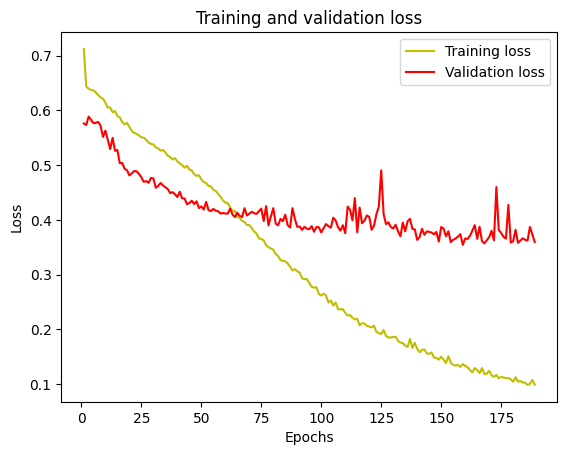

In [16]:
#plot the training and validation IoU and loss at each epoch
loss = history['train_loss']
val_loss = history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

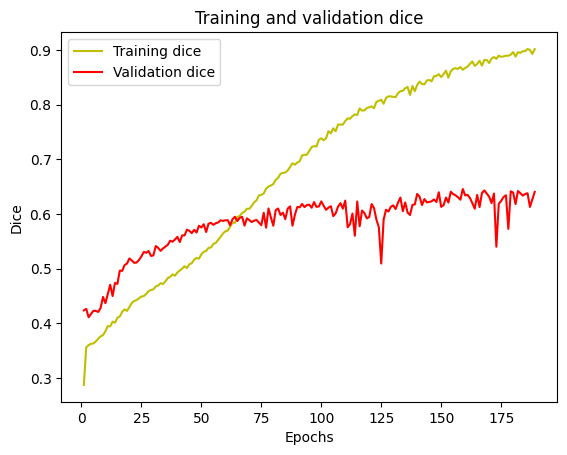

In [17]:
#plot the training and validation IoU and loss at each epoch
loss = history['train_dice']
val_loss = history['val_dice']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training dice')
plt.plot(epochs, val_loss, 'r', label='Validation dice')
plt.title('Training and validation dice')
plt.xlabel('Epochs')
plt.ylabel('Dice')
plt.legend()
plt.show()

In [18]:
num_batches = 1
# Validation
model.eval()
test_dice9 = []
test_dice8 = []
test_dice7 = []
test_dice6 = []
test_dice5 = []
test_dice4 = []
test_dice3 = []
test_dice2 = []
test_dice1 = []
test_dice05 = []
test_dice01 = []
test_dice005 = []
test_dice001 = []
test_dice0005 = []
test_dice0001 = []
test_dice00005 = []
test_dice00001 = []
test_dice000005 = []
test_dice000001 = []
test_dice0000005 = []
test_dice0000001 = []
with torch.no_grad():
    for val_inputs, val_targets in tqdm(test_loader):
        val_inputs = val_inputs.to(device)
        val_targets = val_targets.to(device)
        val_outputs = model(val_inputs)
        #print(np.unique(val_outputs))
        test_outputs = torch.where(val_outputs>0.9,torch.tensor(1),torch.tensor(0))
        test_dice9.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.8,torch.tensor(1),torch.tensor(0))
        test_dice8.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.7,torch.tensor(1),torch.tensor(0))
        test_dice7.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.6,torch.tensor(1),torch.tensor(0))
        test_dice6.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.5,torch.tensor(1),torch.tensor(0))
        test_dice5.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.4,torch.tensor(1),torch.tensor(0))
        test_dice4.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.3,torch.tensor(1),torch.tensor(0))
        test_dice3.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.2,torch.tensor(1),torch.tensor(0))
        test_dice2.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.1,torch.tensor(1),torch.tensor(0))
        test_dice1.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.05,torch.tensor(1),torch.tensor(0))
        test_dice05.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.01,torch.tensor(1),torch.tensor(0))
        test_dice01.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.005,torch.tensor(1),torch.tensor(0))
        test_dice005.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.001,torch.tensor(1),torch.tensor(0))
        test_dice001.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.0005,torch.tensor(1),torch.tensor(0))
        test_dice0005.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.0001,torch.tensor(1),torch.tensor(0))
        test_dice0001.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.00005,torch.tensor(1),torch.tensor(0))
        test_dice00005.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.00001,torch.tensor(1),torch.tensor(0))
        test_dice00001.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.000005,torch.tensor(1),torch.tensor(0))
        test_dice000005.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.000001,torch.tensor(1),torch.tensor(0))
        test_dice000001.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.0000005,torch.tensor(1),torch.tensor(0))
        test_dice0000005.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.0000001,torch.tensor(1),torch.tensor(0))
        test_dice0000001.append(dice_coeff(test_outputs,val_targets).item())
        
        
        

print('Test dice at 0.9: ',np.mean(test_dice9))
print('Test dice at 0.8: ',np.mean(test_dice8))
print('Test dice at 0.7: ',np.mean(test_dice7))
print('Test dice at 0.6: ',np.mean(test_dice6))
print('Test dice at 0.5: ',np.mean(test_dice5))
print('Test dice at 0.4: ',np.mean(test_dice4))
print('Test dice at 0.3: ',np.mean(test_dice3))
print('Test dice at 0.2: ',np.mean(test_dice2))
print('Test dice at 0.1: ',np.mean(test_dice1))
print('Test dice at 0.05: ',np.mean(test_dice05))
print('Test dice at 0.01: ',np.mean(test_dice01))
print('Test dice at 0.005: ',np.mean(test_dice005))
print('Test dice at 0.001: ',np.mean(test_dice001))
print('Test dice at 0.0005: ',np.mean(test_dice0005))
print('Test dice at 0.0001: ',np.mean(test_dice0001))
print('Test dice at 0.00005: ',np.mean(test_dice00005))
print('Test dice at 0.00001: ',np.mean(test_dice00001))
print('Test dice at 0.000005: ',np.mean(test_dice000005))
print('Test dice at 0.000001: ',np.mean(test_dice000001))
print('Test dice at 0.0000005: ',np.mean(test_dice0000005))
print('Test dice at 0.0000001: ',np.mean(test_dice0000001))

  0%|          | 0/200 [00:00<?, ?it/s]

Test dice at 0.9:  0.6198212982212135
Test dice at 0.8:  0.6197529248744832
Test dice at 0.7:  0.6196795956997811
Test dice at 0.6:  0.6196018836881558
Test dice at 0.5:  0.6195974431597279
Test dice at 0.4:  0.6195312698624912
Test dice at 0.3:  0.6194770399537083
Test dice at 0.2:  0.619406035181164
Test dice at 0.1:  0.6192012477565731
Test dice at 0.05:  0.6190099933129386
Test dice at 0.01:  0.6185141563625075
Test dice at 0.005:  0.6180924948358006
Test dice at 0.001:  0.6163191461233509
Test dice at 0.0005:  0.6148777621823683
Test dice at 0.0001:  0.6104662891676708
Test dice at 0.00005:  0.6080392367134846
Test dice at 0.00001:  0.6002418058666809
Test dice at 0.000005:  0.5956301143877499
Test dice at 0.000001:  0.5804842858646225
Test dice at 0.0000005:  0.571952901914301
Test dice at 0.0000001:  0.5479794609877353
